In [1]:
# association rules for movie recommendations

MAX_ENTRIES = 100000

import os
import pandas as pd



DATASET = "DATASET/movies/ratings.csv"
METADATA = "DATASET/movies/movies_metadata.csv"
LINKS = "DATASET/movies/links.csv"

links = pd.read_csv(LINKS, low_memory=False, dtype={'imdbId': str, 'movieId': str})
metadata = pd.read_csv(METADATA, low_memory=False, dtype={'id': str, 'imdb_id': str})

def id_to_imdb_id(id):
    """Retrieves the IMDb ID of the movie with the given ID from the links DataFrame.

    Args:
        id (int): The ID of the movie.
        links (pd.DataFrame): A pandas DataFrame loaded from the CSV file,
                              containing columns like 'movieId' and 'imdbId'.

    Returns:
        str: The IMDb ID of the movie, or "Unknown" if the ID is not found.
    """

    id = str(id)  # Convert to string for comparison

    try:
        # Efficiently access the IMDb ID using boolean indexing
        imdb_id = links[links['movieId'] == id]['imdbId'].values.tolist()[0]
        return imdb_id
    except (KeyError, IndexError):
        # Handle both KeyError (ID not found) and IndexError (empty list)
        raise KeyError(id + " (Unknown)")

def id_to_title(id):
    """Retrieves the title of the movie with the given ID from the metadata DataFrame.

    Args:
        id (int): The ID of the movie.
        metadata (pd.DataFrame): A pandas DataFrame loaded from the CSV file,
                                  containing columns like 'id' and 'title'.

    Returns:
        str: The title of the movie, or "Unknown" if the ID is not found.
    """

    id = str(id)  # Convert to string for comparison
    id = id_to_imdb_id(id)  # Convert to IMDb ID for comparison
    id = "tt" + id  # Prepend "tt" to match IMDb format

    try:
        # Efficiently access the title using boolean indexing
        title = metadata[metadata['imdb_id'] == id]['title'].values.tolist()[0]
        return title
    except (KeyError, IndexError):
        # Handle both KeyError (ID not found) and IndexError (empty list)
        return id + " (Unknown)"
    



if not os.path.exists(DATASET):
    print("Dataset not found")
    print("Please download the dataset from https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv and place it in the DATASET/movies folder")
    exit(1)

import pandas as pd

data = pd.read_csv(DATASET)


# data = data.head(MAX_ENTRIES)

print(data.head())
    


   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556


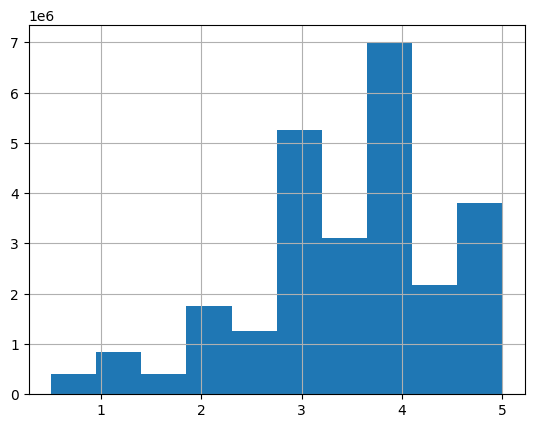

In [14]:
# visualize the data
import matplotlib.pyplot as plt

data['rating'].hist()
plt.show()

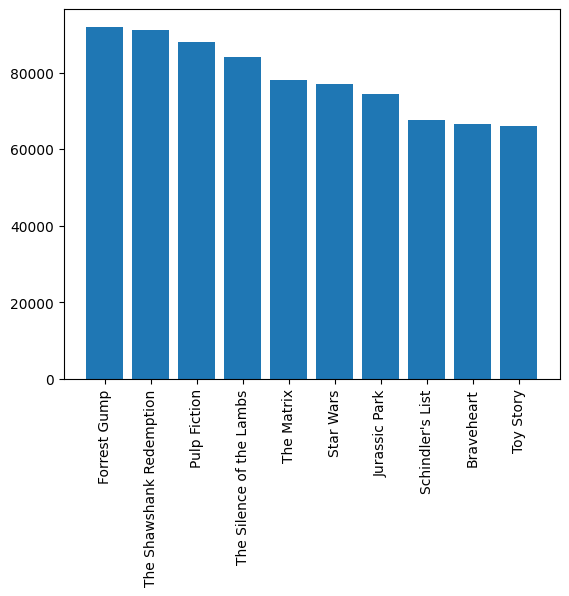

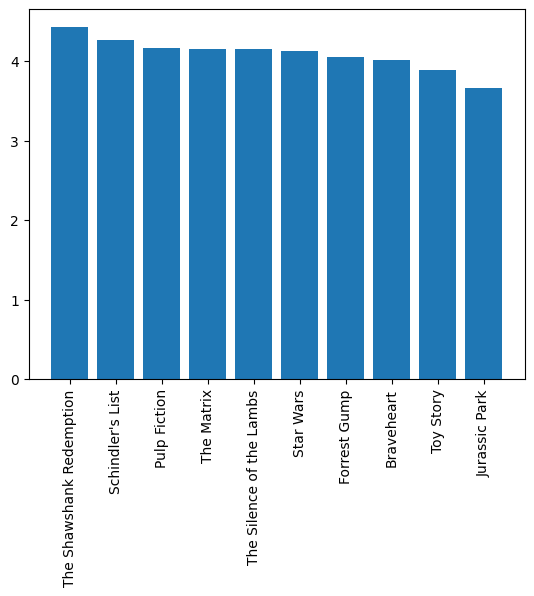

In [9]:
# most popular movies with their ratings
most_rated = data.groupby('movieId').size().sort_values(ascending=False)[:10]

avg_rating = data.groupby('movieId')['rating'].mean()
names = []
for i in most_rated.index:
    names.append(id_to_title(i))

most_rated = pd.DataFrame({'movieId': most_rated.index, 'count': most_rated.values, 'avg_rating': avg_rating[most_rated.index].values, 'title': names})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(most_rated['title'], most_rated['count'])
plt.xticks(rotation=90)
plt.show()

# most rated movies with their average rating
most_rated = most_rated.sort_values(by='avg_rating', ascending=False)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(most_rated['title'], most_rated['avg_rating'])
plt.xticks(rotation=90)
plt.show()



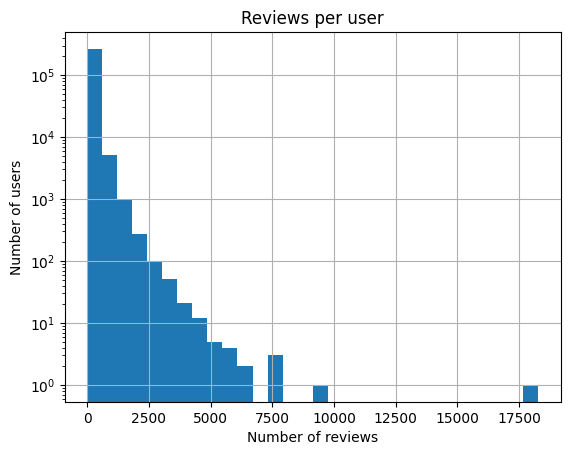

In [7]:
# reviews per user histogram log scale
reviews_per_user = data.groupby('userId').size()
reviews_per_user.hist(bins=30, log=True)
plt.title('Reviews per user')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.show()

In [117]:
# data preprocessing
# normalize rating for each movie:
# devide each rating by the average rating for that movie
# that way, we don't just get the highest rated movies, but movies that are rated higher than average for a user

# then, remove all but the 1000 most rated movies
movie_count = data.groupby('movieId')
movie_count = movie_count['movieId'].count()
movie_count = movie_count.sort_values(ascending=False)

first_1000 = movie_count.head(1000)



data = data[data['movieId'].isin(first_1000.index)]
            

movie_avg = data.groupby('movieId')['rating'].mean()

data = pd.merge(data, movie_avg, on='movieId', suffixes=('', '_avg'))

print(data.head())

# print movie names
for i in range(5):
    print(id_to_title(data['movieId'][i]))

   userId  movieId  rating   timestamp  rating_avg
0       1      110     1.0  1425941529    4.016057
1       1      858     5.0  1425941523    4.339811
2       1     1221     5.0  1425941546    4.263475
3       1     1246     5.0  1425941556    3.912803
4       1     1968     4.0  1425942148    3.827553
Braveheart
The Godfather
The Godfather: Part II
Dead Poets Society
The Breakfast Club


In [118]:
# for each user, get all movies that are rated higher than average
# this is our input data for the association rule algorithm

data = data[data['rating'] > data['rating_avg']]
user_movies = data.groupby('userId')['movieId'].apply(list)

# max 10 movies per user
# first shuffle the list
user_movies = user_movies.sample(frac=1)
user_movies = user_movies.apply(lambda x: x[:10])

print(len(user_movies))
print(user_movies.head())

260435
userId
206984      [21, 39, 95, 110, 216, 260, 342, 345, 348, 380]
141659    [150, 153, 165, 296, 588, 590, 648, 743, 783, ...
153095                                  [527, 3578, 106487]
86798     [32, 266, 364, 527, 924, 1080, 1198, 1199, 120...
82467           [1, 2, 32, 48, 50, 135, 296, 316, 318, 344]
Name: movieId, dtype: object


In [119]:
# print movies of user 1
for movie in user_movies[66]:
    print(id_to_title(movie))

Tommy Boy
So I Married an Axe Murderer
Kingpin
Glory
Liar Liar
The Thomas Crown Affair
Almost Famous


In [120]:
# convert the data to a format that the mlxtend library can use
# we need to convert the data to a list of lists, where each list is a list of movies that a user has rated higher than average
from mlxtend.preprocessing import TransactionEncoder


te = TransactionEncoder()
te_ary = te.fit(user_movies).transform(user_movies)
df = pd.DataFrame(te_ary, columns=te.columns_)



print(df.head())

print("Data shape: ", df.shape)


   1       2       3       5       6       7       10      11      14      \
0   False   False   False   False   False   False   False   False   False   
1   False   False   False   False   False   False   False   False   False   
2   False   False   False   False   False   False   False   False   False   
3   False   False   False   False   False   False   False   False   False   
4    True    True   False   False   False   False   False   False   False   

   16      ...  112556  112852  115617  115713  116797  122882  122886  \
0   False  ...   False   False   False   False   False   False   False   
1   False  ...   False   False   False   False   False   False   False   
2   False  ...   False   False   False   False   False   False   False   
3   False  ...   False   False   False   False   False   False   False   
4   False  ...   False   False   False   False   False   False   False   

   122904  134130  134853  
0   False   False   False  
1   False   False   False  
2   Fals

In [128]:
# apply the apriori algorithm to find association rules
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

print(len(frequent_itemsets))

# find association rules
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.55)

print(rules)

455
     antecedents consequents  antecedent support  consequent support  \
0           (29)        (32)            0.025918            0.135231   
1          (161)       (150)            0.040555            0.122929   
2         (1196)       (260)            0.033674            0.113345   
3         (1221)       (858)            0.019537            0.061420   
4       (32, 34)         (1)            0.022171            0.166414   
5        (16, 6)        (32)            0.020408            0.135231   
6        (6, 47)        (32)            0.019986            0.135231   
7        (6, 47)        (50)            0.019986            0.120249   
8     (153, 110)       (150)            0.018888            0.122929   
9     (153, 161)       (150)            0.017805            0.122929   
10    (153, 165)       (150)            0.020907            0.122929   
11   (1210, 260)      (1196)            0.017068            0.033674   
12  (1210, 1196)       (260)            0.014199            

In [129]:
# apply fp-growth algorithm to find frequent itemsets
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)

print(frequent_itemsets)

# find association rules
fp_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.55)

print(fp_rules)


      support     itemsets
0    0.113345        (260)
1    0.095717        (110)
2    0.055265         (39)
3    0.051057         (21)
4    0.028376         (95)
..        ...          ...
450  0.015601     (1, 141)
451  0.010363    (141, 62)
452  0.010026   (185, 150)
453  0.013835  (858, 1221)
454  0.010390   (260, 541)

[455 rows x 2 columns]
     antecedents consequents  antecedent support  consequent support  \
0     (153, 110)       (150)            0.018888            0.122929   
1     (153, 165)       (150)            0.020907            0.122929   
2     (356, 527)       (318)            0.016876            0.156427   
3     (296, 356)       (318)            0.024582            0.156427   
4       (32, 34)         (1)            0.022171            0.166414   
5        (6, 47)        (50)            0.019986            0.120249   
6        (6, 47)        (32)            0.019986            0.135231   
7        (16, 6)        (32)            0.020408            0.135231   
8   

In [130]:

# print the rules in a human-readable format


def print_rule(rule):
    antecedent = rule['antecedents']
    consequent = rule['consequents']
    antecedent = [id_to_title(a) for a in antecedent]
    consequent = [id_to_title(c) for c in consequent]
    print(antecedent, " -> ", consequent, " (", rule['support'], ", ", rule['confidence'], ")")

print("Apriori rules:")
print("Antecedent -> Consequent (support, confidence)")
for i in range(len(rules)):
    print_rule(rules.iloc[i])

print("FP-growth rules:")
print("Antecedent -> Consequent (support, confidence)")
for i in range(len(fp_rules)):
    print_rule(fp_rules.iloc[i])



Apriori rules:
Antecedent -> Consequent (support, confidence)
['The City of Lost Children']  ->  ['Twelve Monkeys']  ( 0.014932708737304894 ,  0.5761481481481482 )
['Crimson Tide']  ->  ['Apollo 13']  ( 0.02454355213392977 ,  0.6051884112857413 )
['The Empire Strikes Back']  ->  ['Star Wars']  ( 0.02136425595638067 ,  0.634435575826682 )
['The Godfather: Part II']  ->  ['The Godfather']  ( 0.013834546047958224 ,  0.7081367924528302 )
['Twelve Monkeys', 'Babe']  ->  ['Toy Story']  ( 0.012279455526330946 ,  0.5538621406304122 )
['Casino', 'Heat']  ->  ['Twelve Monkeys']  ( 0.011304164186841246 ,  0.5539040451552211 )
['Heat', 'Se7en']  ->  ['Twelve Monkeys']  ( 0.011937719584541248 ,  0.5973102785782901 )
['Heat', 'Se7en']  ->  ['The Usual Suspects']  ( 0.011557586345921246 ,  0.5782901056676273 )
['Batman Forever', 'Braveheart']  ->  ['Apollo 13']  ( 0.010451744197208516 ,  0.5533645049806871 )
['Batman Forever', 'Crimson Tide']  ->  ['Apollo 13']  ( 0.012264096607598826 ,  0.6888074185